In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('punkt')
stemmer = SnowballStemmer('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import fowlkes_mallows_score

import seaborn as sns


from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lidag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lidag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv("Lyrics-Genre-Train.csv")

In [3]:
data2 = []
for i in range(0, len(data.index)):

    # Punctuation removal
    table = str.maketrans(dict.fromkeys(string.punctuation))                   
    sentences = (data.Lyrics[i].translate(table))

    # " '\n " removal
    words = sentences[:-3] 

    # Tokenization
    words = nltk.word_tokenize(words)

    # shrt words removal & lemmatization & stemming
    words_ = []
    for word in words:
        if len(word) > 2:   
            if not word.isnumeric():                                                  
                word1 = stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))          
                words_.append(word1)
    data2.append(words_)  

In [4]:
df = pd.DataFrame({'lyr':data2, 'gen':data['Genre']})   

In [5]:
train_data__ = df['lyr']
train_labels = df['gen']

In [6]:
data1 = pd.read_csv("Lyrics-Genre-Test-GroundTruth.csv")

In [7]:
data21 = []
for i in range(0, len(data1.index)):

    # Punctuation removal
    table = str.maketrans(dict.fromkeys(string.punctuation))                   
    sentences1 = (data1.Lyrics[i].translate(table))

    # " '\n " removal
    words1 = sentences1[:-3] 

    # Tokenization
    words1 = nltk.word_tokenize(words1)

    # shrt words removal & lemmatization & stemming
    words_1 = []
    for word in words1:
        if len(word) > 2:   
            if not word.isnumeric():                                                  
                word1 = stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))          
                words_1.append(word1)
    data21.append(words_1)  

In [8]:
df1 = pd.DataFrame({'lyr':data21, 'gen':data1['Genre']})   

test_data__ = df1['lyr']
test_labels = df1['gen']

In [9]:
# CountVectorizer & TermFrequencies
cvect = CountVectorizer(ngram_range=(1, 1), lowercase='true')   
tfidf_transformer = TfidfTransformer(norm= 'l2', use_idf= True)

In [10]:
# Transforming the processed data to a list (for tfidf)
data4 = train_data__.astype(str).values.tolist()

train_data1 = cvect.fit_transform(data4)
train_data = tfidf_transformer.fit_transform(train_data1)

In [11]:
# Same procedure for the test data
data5 = test_data__.astype(str).values.tolist()

test_data1 = cvect.transform(data5)
test_data = tfidf_transformer.transform(test_data1)

In [12]:
# Same procedure for the entire data set
train_data6 = df['lyr'].astype(str).values.tolist()

data1_ = cvect.fit_transform(train_data6)
data_ = tfidf_transformer.fit_transform(data1_)

## Naive Bayes 0.41(on test) and 0.74(on train) 

In [13]:
# Model fitting
model = MultinomialNB(alpha = 0.01)
model.fit(train_data, train_labels)

MultinomialNB(alpha=0.01)

In [14]:
# Prediction
prediction = model.predict(test_data)

In [15]:
accuracy_score(test_labels, prediction) 

0.41033396345305606

In [16]:
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

     Country       0.48      0.42      0.45       810
  Electronic       0.30      0.05      0.09       660
        Folk       0.54      0.23      0.33       495
     Hip-Hop       0.65      0.81      0.72       960
       Indie       0.32      0.05      0.08       510
        Jazz       0.51      0.27      0.35       660
       Metal       0.62      0.61      0.62       810
         Pop       0.29      0.39      0.34      1110
         R&B       0.49      0.08      0.14       510
        Rock       0.28      0.58      0.38      1410

    accuracy                           0.41      7935
   macro avg       0.45      0.35      0.35      7935
weighted avg       0.44      0.41      0.38      7935



In [ ]:
models = Pipeline([('CountVect', CountVectorizer()), 
                     ('TermFreq', TfidfTransformer()), 
                     ('NB', MultinomialNB())]) 

parameters = { 'CountVect__ngram_range': [(1, 1), (1, 2), (2, 2),(4,5)], 
              'TermFreq__use_idf': (True, False), 
              'TermFreq__norm': ('l1', 'l2'), 
              'NB__alpha': [1, 1e-1, 1e-2, 1e-3] } 

CrossValFolds = 5
grid_search= GridSearchCV(models, parameters, cv = CrossValFolds, n_jobs = -1) 
grid_search.fit(data4, train_labels)

print(grid_search.best_score_) 
print(grid_search.best_params_)

In [ ]:
confusion_matrix(test_labels, prediction, )

## K-means

In [13]:
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0).fit(data_)


In [14]:
kmeans_pred = []
for label in kmeans.predict(test_data):
    if label == 0:
        kmeans_pred.append(1)
    else:
        kmeans_pred.append(0)

In [15]:
fowlkes_mallows_score(kmeans_pred, test_labels) 

0.32170116979674773

In [ ]:
Y = []
for k in range(1,25):
    kmean_ = KMeans(n_clusters=k).fit(data_)
    Y.append(kmean_.inertia_)

In [ ]:
X = range(1,25)

plt.figure(figsize=(12,6))
plt.plot(X, Y)
plt.plot(10, 12596, 'gD')

plt.text(11.8, 12553, 'Elbow point', bbox=dict(color='green', alpha=0.8))
plt.text(11.5, 12700, 'k = 2', fontsize = 12)

plt.ylabel('Squared distances sum')
plt.xlabel('No of clusters')
plt.title('Elbow Method')

plt.show()

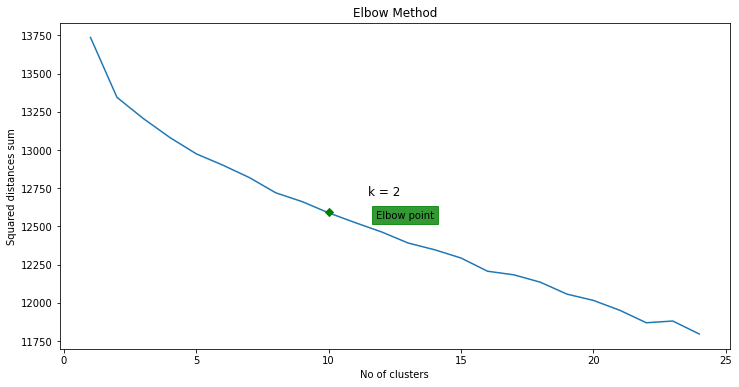

## DBSCAN

In [ ]:
# Dimensionality reduction
SVD = TruncatedSVD(100)
Pca = SVD.fit_transform(data_)

# Makeing the data positive
scaler = MinMaxScaler().fit(Pca)
data_ = scaler.transform(Pca)

In [ ]:
clustering = DBSCAN(eps=0.8, min_samples=4).fit(test_data)

In [ ]:
fowlkes_mallows_score(clustering.labels_, test_labels)

In [ ]:
# Computing a tabel for parameter comparison

Acc = []
Param = []
X_ = []
print('Clusters \t Acc \t eps \t min_samples')
for eps_ in [ 0.6, 0.8, 0.9]:
    for min_samples_ in range(1, 11):
        clustering = DBSCAN(eps=eps_, min_samples=min_samples_).fit(data_)
        n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        print( n_clusters,' \t       ', round(fowlkes_mallows_score(clustering.labels_, test_labels), 3),'\t ', eps_, '  \t ', min_samples_)
        
        X_.append(fowlkes_mallows_score(clustering.labels_, test_labels))
        if n_clusters == 10 or n_clusters == 9:
            Acc.append(fowlkes_mallows_score(clustering.labels_, test_labels))
            Param.append([eps_, min_samples_])

In [ ]:
print('Best score: ', max(Acc),'\nBest Parameters: eps_ = ', Param[np.argmax(Acc, axis = 0)][0], ', min_sample = ', Param[np.argmax(Acc, axis = 0)][1])

In [ ]:
Y_ = range(0,30)

plt.figure(figsize=(12,6))
plt.plot(Y_, X_)
plt.plot(22, 0.285, 'gD')

plt.text(20.2, 0.265, 'Maximum accuracy', bbox=dict(color='green', alpha=0.8))
plt.text(19.4, 0.245, 'eps_ =  0.9 , min_sample =  1', fontsize = 10)

plt.xlabel('Accuracy')
plt.ylabel('Parameters')
plt.title('Best Parameters DBSCAN')

plt.show()

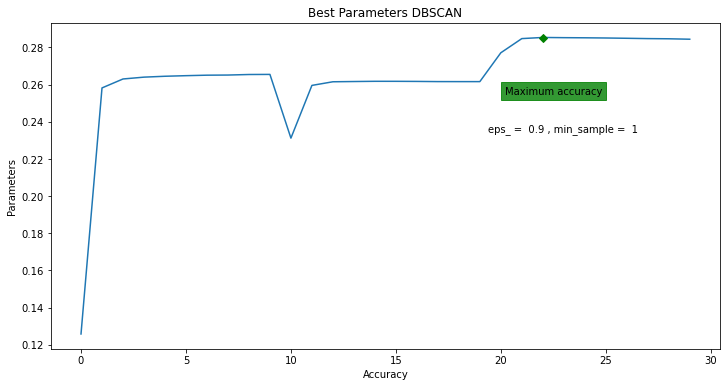